# LiH

## **Step 0**: Setup

In [18]:
import numpy as np

# Qiskit circuit libraries
from qiskit.circuit.library import EfficientSU2

# Qiskit primitives
from qiskit.primitives import Estimator as QiskitEstimator
from qiskit.primitives import Sampler as QiskitSampler

# Qiskit runtime
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_ibm_runtime import Estimator, Sampler, Session

# PySCF itself
import pyscf

# Convert to QCSchema
from chemist_converter import pyscf_to_qcschema, qcschema_to_electronic_structure

# Chemistry transformations
from passes.transformations import ActiveSpaceTransformer
from passes.mappings import (ElectronicStructureToFermionicHamiltonian,
                             JordanWignerMapper,
                             ParityMapper,
                             BravyiKitaevMapper)

# Fulqrum workflow
from fulqrum import Workflow

# SPSA
from spsa import minimize_spsa

## **Step 1** Map the problem to a Quantum Native format (Set of Operators, and a set of Quantum Circuits)

### PySCF to QCSchema

In [19]:
mol = pyscf.M(atom = 'Li .0 .0 .0; H .0 .0 1.6',
              basis = 'sto-3g',
              charge=0,
              spin=0,
              )

mf = pyscf.scf.RHF(mol).run(verbose=False)
schema = pyscf_to_qcschema(mf)

### Optionally save to file

In [28]:
#schema.to_json_file('LiH.json')

### Electronic structure to qubit hamiltonian

In [20]:
elec_struct  = qcschema_to_electronic_structure(schema)

chem_workflow = Workflow([ActiveSpaceTransformer(2, 3),
                          ElectronicStructureToFermionicHamiltonian(),
                          JordanWignerMapper(),
                          #BravyiKitaevMapper(),
                        ])

hamiltonian = chem_workflow.run(electronic_structure=elec_struct)
hamiltonian
#reduced_elec_struct = ActiveSpaceTransformer(2, 3).run(elec_struct)
#fermi_hamiltonian = ElectronicStructureToFermionicHamiltonian().run(reduced_elec_struct)
#hamiltonian = JordanWignerMapper().run(fermi_hamiltonian)

SparsePauliOp(['IIIIII', 'IIIIIZ', 'IIIIZI', 'IIIIZZ', 'IIIZII', 'IIIZIZ', 'IIZIII', 'IIZIIZ', 'IYYIII', 'IYYIIZ', 'IXXIII', 'IXXIIZ', 'IZIIII', 'IZIIIZ', 'ZIIIII', 'ZIIIIZ', 'IIIIYY', 'IIIZYY', 'IIIIXX', 'IIIZXX', 'IIZIYY', 'IIZIXX', 'IYYIYY', 'IXXIYY', 'IYYIXX', 'IXXIXX', 'IZIIYY', 'IZIIXX', 'ZIIIYY', 'ZIIIXX', 'YZYYZY', 'XZXYZY', 'YZYXZX', 'XZXXZX', 'YYIYZY', 'XXIYZY', 'YYIXZX', 'XXIXZX', 'IIIZZI', 'IIZIZI', 'IYYIZI', 'IXXIZI', 'IZIIZI', 'ZIIIZI', 'YZYYYI', 'XZXYYI', 'YZYXXI', 'XZXXXI', 'YYIYYI', 'XXIYYI', 'YYIXXI', 'XXIXXI', 'IIZZII', 'IYYZII', 'IXXZII', 'IZIZII', 'ZIIZII', 'IZZIII', 'ZIZIII', 'ZYYIII', 'ZXXIII', 'ZZIIII'],
              coeffs=[-0.46007434+0.j,  0.02669401+0.j, -0.14571632+0.j,  0.05263652+0.j,
 -0.16165347+0.j,  0.0616872 +0.j,  0.02669401+0.j,  0.12182774+0.j,
  0.01208048+0.j,  0.0121449 +0.j,  0.01208048+0.j,  0.0121449 +0.j,
 -0.14571632+0.j,  0.05590251+0.j, -0.16165347+0.j,  0.06754287+0.j,
  0.01208048+0.j,  0.00337735+0.j,  0.01208048+0.j,  0.00337735+0.j

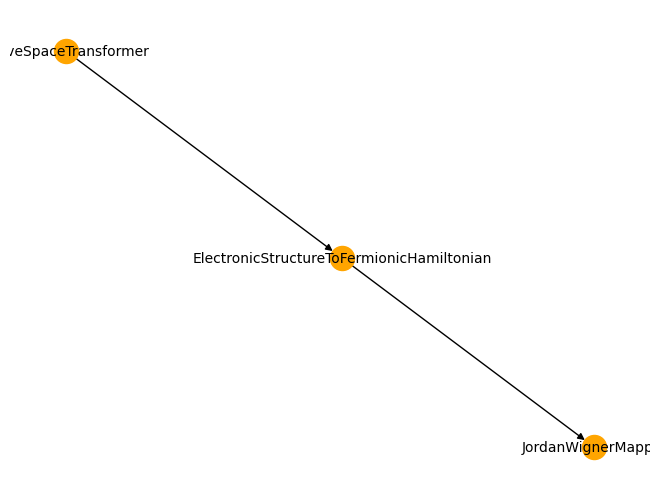

In [21]:
chem_workflow.draw()

### Ansatz circuit

In [22]:
ansatz = EfficientSU2(num_qubits=hamiltonian.num_qubits, reps=1, entanglement='linear')

## **Step 2**: Optimize the circuits and the operators to be measured

None here, letting the primitives handle it.

## **Step 3**: Execute using a quantum primitive function (estimator or sampler)


In [23]:
def cost_func(params, ansatz, hamiltonian, estimator):
    """Return estimate of energy from estimator

    Parameters:
        params (ndarray): Array of ansatz parameters
        ansatz (QuantumCircuit): Parameterized ansatz circuit
        hamiltonian (SparsePauliOp): Operator representation of Hamiltonian
        estimator (Estimator): Estimator primitive instance

    Returns:
        float: Energy estimate
    """
    cost = estimator.run(ansatz, hamiltonian, parameter_values=params).result().values[0]
    return cost

In [24]:
estimator = QiskitEstimator(options={"shots": int(1e4)})
sampler = QiskitSampler(options={"shots": int(1e4)})

In [25]:
x0 = 2*np.pi*np.random.random(size=ansatz.num_parameters)
res = minimize_spsa(cost_func, x0, args=(ansatz, hamiltonian, estimator), maxiter=250)

In [26]:
res

 message: Optimization terminated successfully.
 success: True
     fun: -0.9186226659725594
       x: [ 6.256e+00  3.107e+00 ...  2.712e+00  6.092e+00]
     nit: 250
    nfev: 500

## **Step 4**: Post-processing of the results

In [27]:
res.fun

-0.9186226659725594